In [2]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Any, Dict, List, Optional, Tuple
from tqdm import tqdm

___ 
## Covariance Matrix
___

In [143]:
raw_corr = pd.read_csv("./correlation/correlation_old_total.csv").drop(columns=["Unnamed: 0"])

391


In [148]:
dirData_raw = "../data/raw/"
dirData_clean = dirData_raw.replace("raw","clean")+"normal/"
if not os.path.isdir(dirData_clean):
    os.makedirs(dirData_clean)

tickers = os.listdir(dirData_clean)
#tickers.remove('.DS_Store')

N = len(tickers)
T = 10**4

print(N)

392


In [101]:
# Hayashi-Yoshida estimator for the correlation matrix

def hayashi_yoshida(tickers: List[str], dirData_clean: str, folder: str) -> np.ndarray:

    N = len(tickers)

    corr_hy = np.zeros((N, N))

    for i, ticker1 in tqdm(enumerate(tickers)):
        for j, ticker2 in enumerate(tickers):
            if i<j:
                continue
            asset1 = pd.read_parquet(dirData_clean + folder + ticker1 + "-trade.parquet")
            asset2 = pd.read_parquet(dirData_clean + folder + ticker2 + "-trade.parquet")

            asset_merged = asset1.merge(asset2, on="index", how="outer")
            asset_merged = asset_merged.ffill().bfill()

            corr_hy[i, j] = sum(asset_merged.iloc[:,1].to_numpy()*asset_merged.iloc[:,2].to_numpy()) / asset_merged.shape[0]
            corr_hy[j, i] = corr_hy[i, j]

    return corr_hy

___
## Eigenvalues Analysis
___

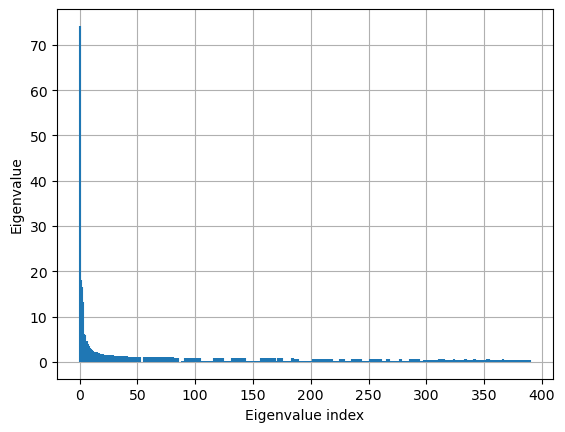

In [102]:
eigvals, eigvecs = np.linalg.eig(raw_corr)

plt.stem(eigvals, markerfmt=" ", basefmt=" ")
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

In [103]:
# Marchenko-Pastur Distribution

def MP0(lambdas,q,sigma2):

    x = np.linspace(0.01, np.max(lambdas)+0.2, 1000)
    lambda_plus = sigma2*(1+np.sqrt(q))**2
    lambda_minus = sigma2*(1-np.sqrt(q))**2

    vals = (lambda_plus-x)*(x-lambda_minus)
    
    vals = np.where(vals>0, 1/(q*2*np.pi*x*sigma2)*np.sqrt(vals), 0)

    return x, vals

### Eigenvalue Clipping

In [104]:
def eigenvalue_clipping(eigvals, eigvecs, q, sigma2):

    lambda_p = sigma2*(1+np.sqrt(q))**2
    N_clip = np.sum(np.where(eigvals<=lambda_p, 1, 0))
    delta = (N - np.sum(np.where(eigvals>=lambda_p, eigvals, 0)))/N_clip
    eig_clip = np.where(eigvals<=lambda_p, delta, eigvals)

    C_clip = eigvecs.T@np.diag(eig_clip)@eigvecs
    eigvals_clean, eigvecs_clean = np.linalg.eig(C_clip)

    return eigvals_clean, eigvecs_clean


- **Raw Correlation Matrix**

/var/folders/5j/w6vdlj1n4fq45bh11q5mwhkw0000gn/T/ipykernel_78114/3615201271.py:11: RuntimeWarning: invalid value encountered in sqrt
  vals = np.where(vals>0, 1/(q*2*np.pi*x*sigma2)*np.sqrt(vals), 0)
/var/folders/5j/w6vdlj1n4fq45bh11q5mwhkw0000gn/T/ipykernel_78114/3615201271.py:11: RuntimeWarning: invalid value encountered in sqrt
  vals = np.where(vals>0, 1/(q*2*np.pi*x*sigma2)*np.sqrt(vals), 0)


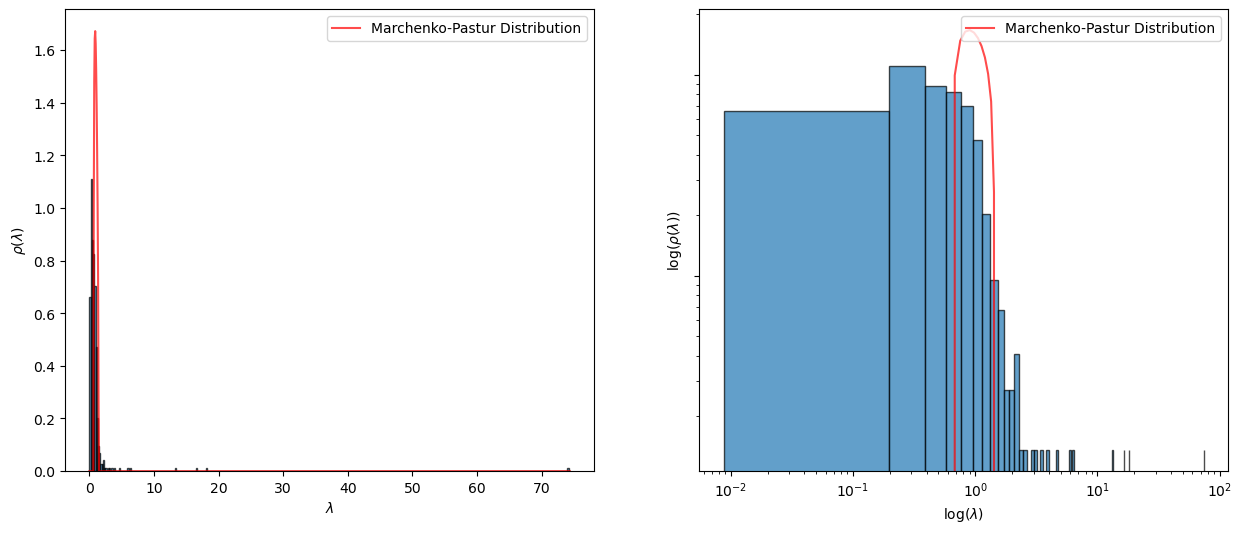

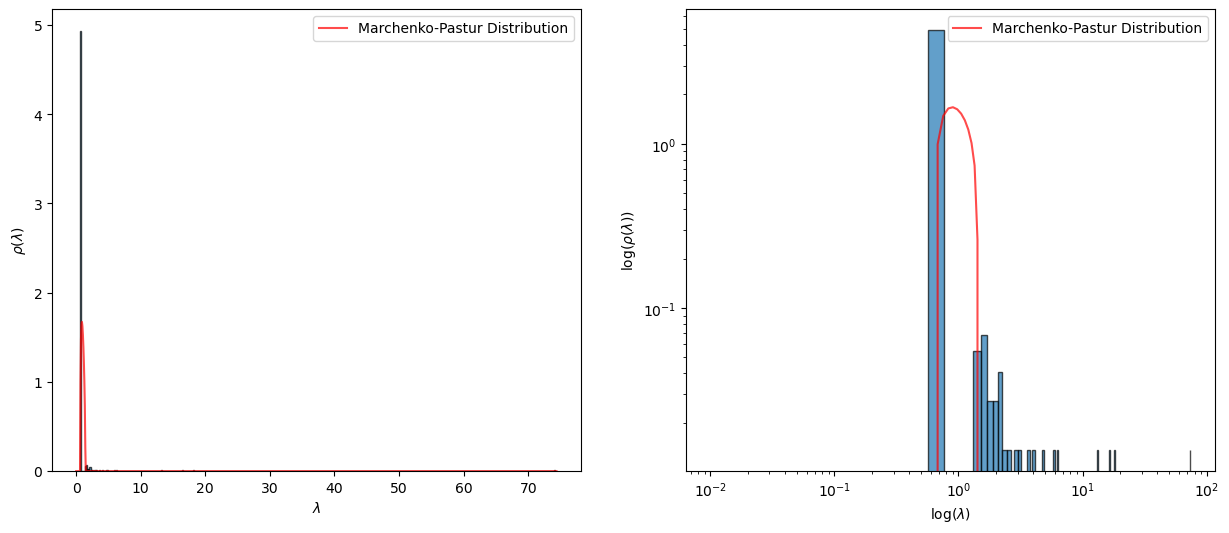

In [105]:
q = N/T
sigma2 = 1 

eigvals_clean, eigvec_clean = eigenvalue_clipping(eigvals, eigvecs, q, sigma2)

# Plots of original eigenvalues

fig, ax = plt.subplots(1, 2, figsize=(15,6))

x, mp0 = MP0(eigvals,q,sigma2)
ax[0].hist(eigvals, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[0].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\rho(\lambda)$')
ax[0].legend()

x, mp0 = MP0(eigvals,q,sigma2)
ax[1].hist(eigvals, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[1].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\log(\lambda$)')
ax[1].set_ylabel(r'$\log(\rho(\lambda))$')
ax[1].set_yticklabels([])
ax[1].legend(loc='upper right')

# Plots of clipped eigenvalues

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

x, mp0 = MP0(eigvals_clean,q,sigma2)
ax[0].hist(eigvals_clean, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[0].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\rho(\lambda)$')
ax[0].legend()

x, mp0 = MP0(eigvals_clean,q,sigma2)
ax[1].hist(eigvals_clean, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[1].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\log(\lambda$)')
ax[1].set_ylabel(r'$\log(\rho(\lambda))$')
ax[1].legend(loc='upper right')

plt.show()

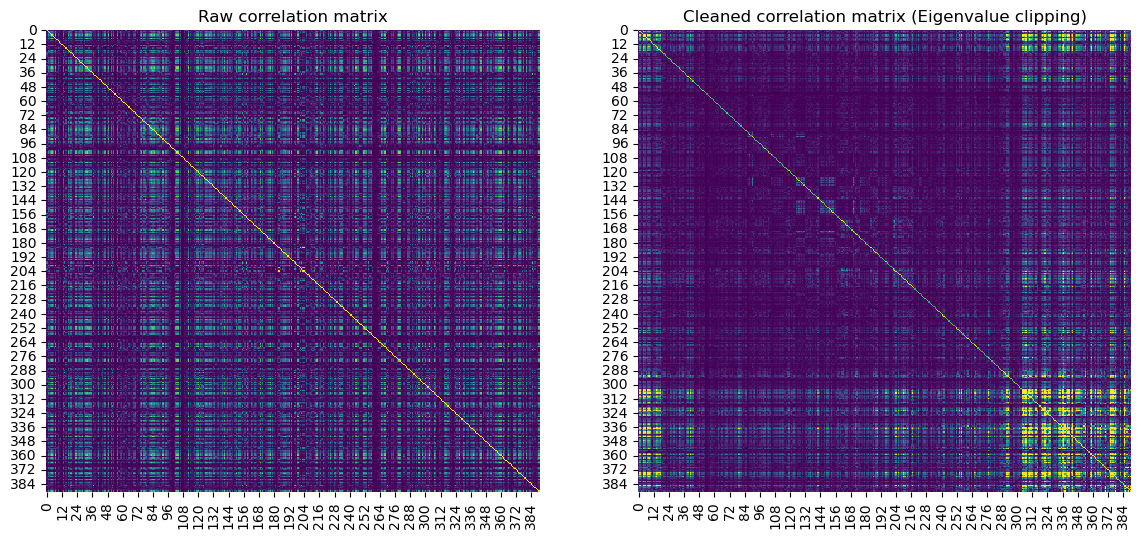

In [109]:
correlation_raw_clean = eigvecs.T @ np.diag(eigvals_clean) @ eigvecs

correlation_raw_clean = np.where(correlation_raw_clean>1, 1, correlation_raw_clean)
correlation_raw_clean = np.where(correlation_raw_clean<-1, -1, correlation_raw_clean)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(np.abs(raw_corr), cmap="viridis", ax=ax[0], cbar=False)
ax[0].set_title("Raw correlation matrix")

sns.heatmap(np.abs(correlation_raw_clean), cmap="viridis", ax=ax[1], cbar=False)
ax[1].set_title("Cleaned correlation matrix (Eigenvalue clipping)")

plt.show()

- **Hayashi-Yoshida Correlation Matrix (1 Day)**

/var/folders/5j/w6vdlj1n4fq45bh11q5mwhkw0000gn/T/ipykernel_78114/3615201271.py:11: RuntimeWarning: invalid value encountered in sqrt
  vals = np.where(vals>0, 1/(q*2*np.pi*x*sigma2)*np.sqrt(vals), 0)


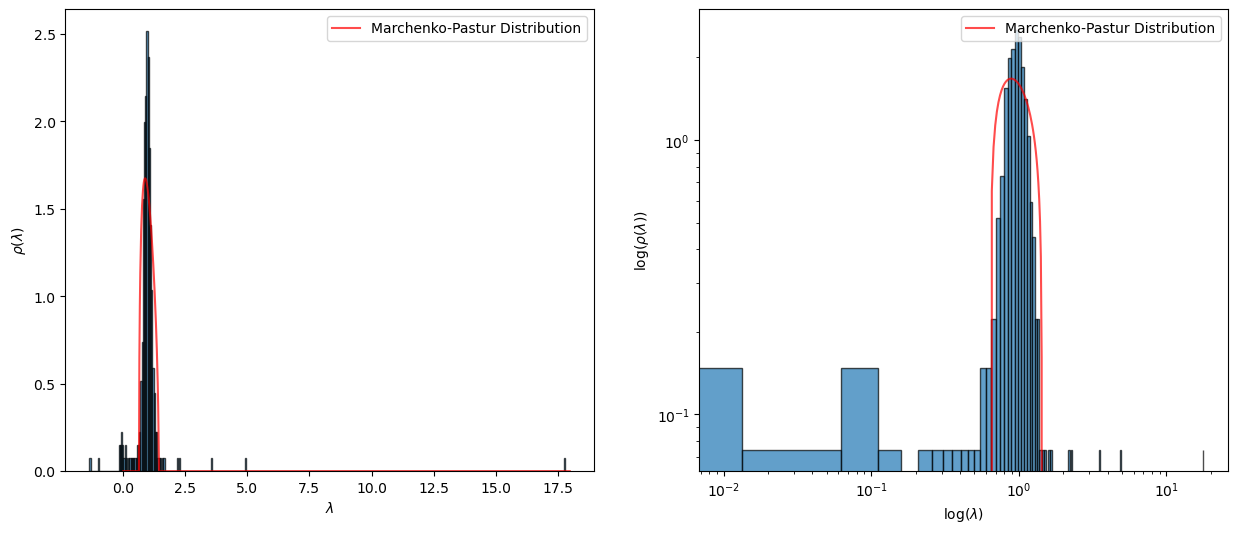

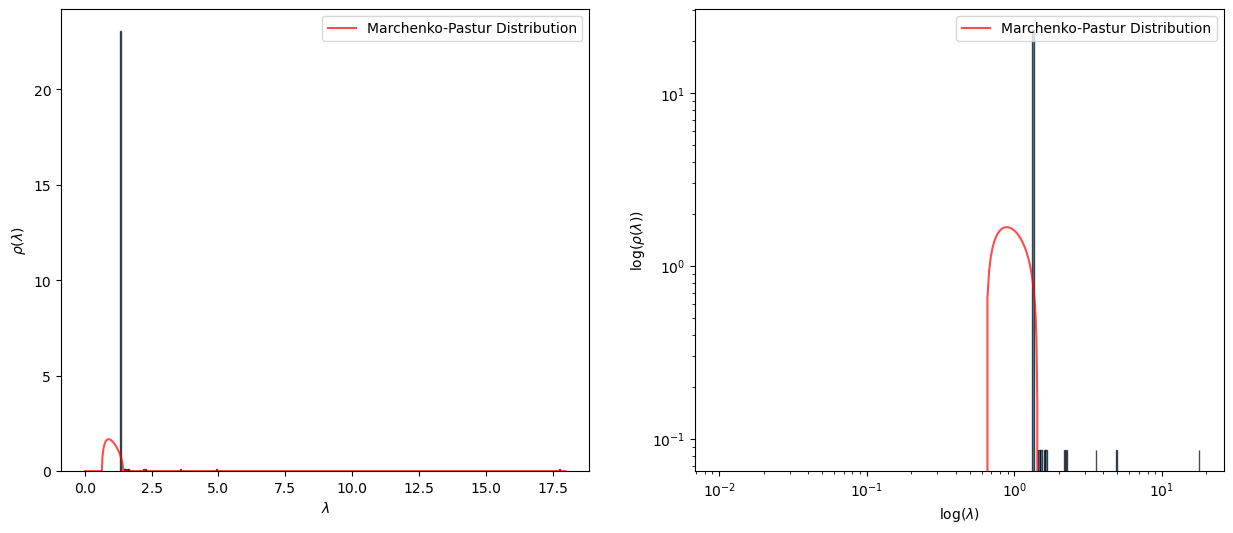

In [110]:
correlation_hy_1day = pd.read_csv("./correlation/correlation_hy_0305.csv").drop(columns=["Unnamed: 0"])


eigvals_hy_1day, eigvecs_hy_1day = np.linalg.eig(correlation_hy_1day)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

x, mp0 = MP0(eigvals_hy_1day,q,sigma2)
ax[0].hist(eigvals_hy_1day, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[0].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\rho(\lambda)$')
ax[0].legend()

x, mp0 = MP0(eigvals_hy_1day,q,sigma2)
ax[1].hist(eigvals_hy_1day, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[1].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\log(\lambda$)')
ax[1].set_ylabel(r'$\log(\rho(\lambda))$')
ax[1].legend(loc='upper right')

plt.show()


# Eigenvalue clipping

eigvals_hy_1day_clean, eigvecs_hy_1day_clean = eigenvalue_clipping(eigvals_hy_1day, eigvecs_hy_1day, q, sigma2)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

x, mp0 = MP0(eigvals_hy_1day_clean,q,sigma2)
ax[0].hist(eigvals_hy_1day_clean, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[0].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\rho(\lambda)$')
ax[0].legend()

x, mp0 = MP0(eigvals_hy_1day_clean,q,sigma2)
ax[1].hist(eigvals_hy_1day_clean, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[1].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\log(\lambda$)')
ax[1].set_ylabel(r'$\log(\rho(\lambda))$')
ax[1].legend(loc='upper right')

plt.show()

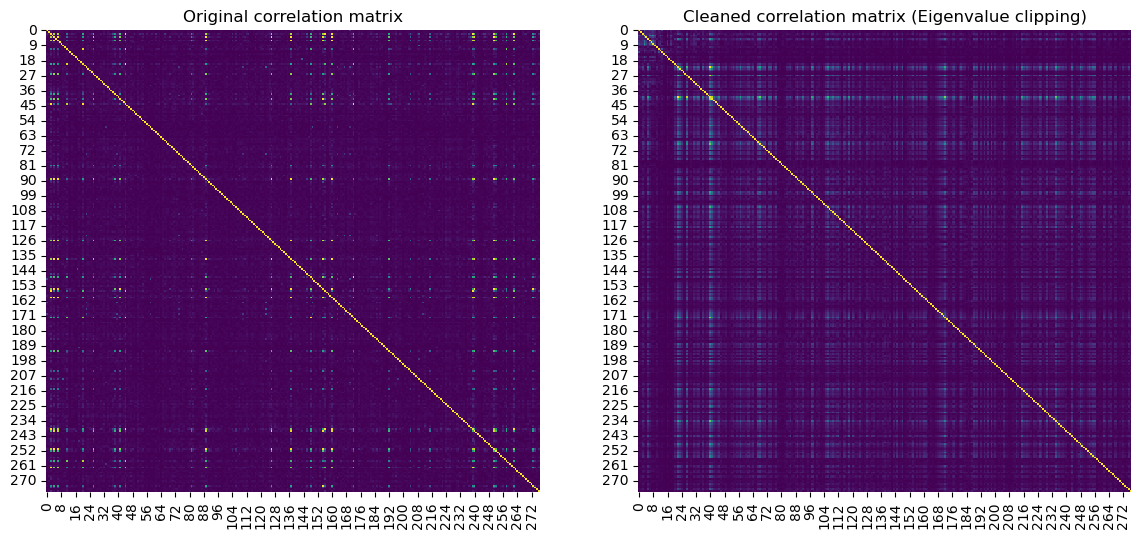

In [111]:
correlation_hy_1day_clean = eigvecs_hy_1day.T @ np.diag(eigvals_hy_1day_clean) @ eigvecs_hy_1day

correlation_hy_1day_clean = np.where(correlation_hy_1day_clean>1, 1, correlation_hy_1day_clean)
correlation_hy_1day_clean = np.where(correlation_hy_1day_clean<-1, -1, correlation_hy_1day_clean)

correlation_hy_1day = np.where(correlation_hy_1day>1, 1, correlation_hy_1day)
correlation_hy_1day = np.where(correlation_hy_1day<-1, -1, correlation_hy_1day)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(np.abs(correlation_hy_1day), cmap="viridis", ax=ax[0], cbar=False)
ax[0].set_title("Original correlation matrix")

sns.heatmap(np.abs(correlation_hy_1day_clean), cmap="viridis", ax=ax[1], cbar=False)
ax[1].set_title("Cleaned correlation matrix (Eigenvalue clipping)")

plt.show()

- **Sector Clustering**

In [120]:
import yfinance as yf

def fetch_sector(
    ticker: str,
) -> Tuple[str, Optional[str]]:
    """
    Fetches the sector for a given stock ticker using the yfinance library.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        Tuple[str, Optional[str]]: A tuple containing the ticker and its sector.
    """
    try:
        stock = yf.Ticker(ticker)
        sector = stock.info.get("sector")
        return ticker, sector
    except Exception:
        return ticker, 'None'

In [ ]:
tickers_hy_0305 = list(np.load("tickers_filtered.npy"))

tickers_sectors = [fetch_sector(ticker) for ticker in tickers_hy_0305]

# Replace None with 'None'
tickers_sectors = [(ticker, sector if sector is not None else 'None') for ticker, sector in tickers_sectors]

tickers_sectors = sorted(tickers_sectors, key=lambda x: x[1])

np.save("tickers_sectors_filtered.npy", tickers_sectors)

In [155]:
tickers_sorted = [ticker for ticker, sector in tickers_sectors]

idx_mapping = {old: new for old, new in zip(tickers_hy_0305, tickers_sorted)}
new_order = [tickers_hy_0305.index(idx_mapping[ticker]) for ticker in tickers_hy_0305]

# Reorder the correlation matrices
# raw_corr_sorted = raw_corr[new_order][:, new_order]
# correlation_raw_clean_sorted = correlation_raw_clean[new_order][:, new_order]

correlation_hy_1day_sorted = correlation_hy_1day[new_order][:, new_order]
correlation_hy_1day_clean_sorted = correlation_hy_1day_clean[new_order][:, new_order]

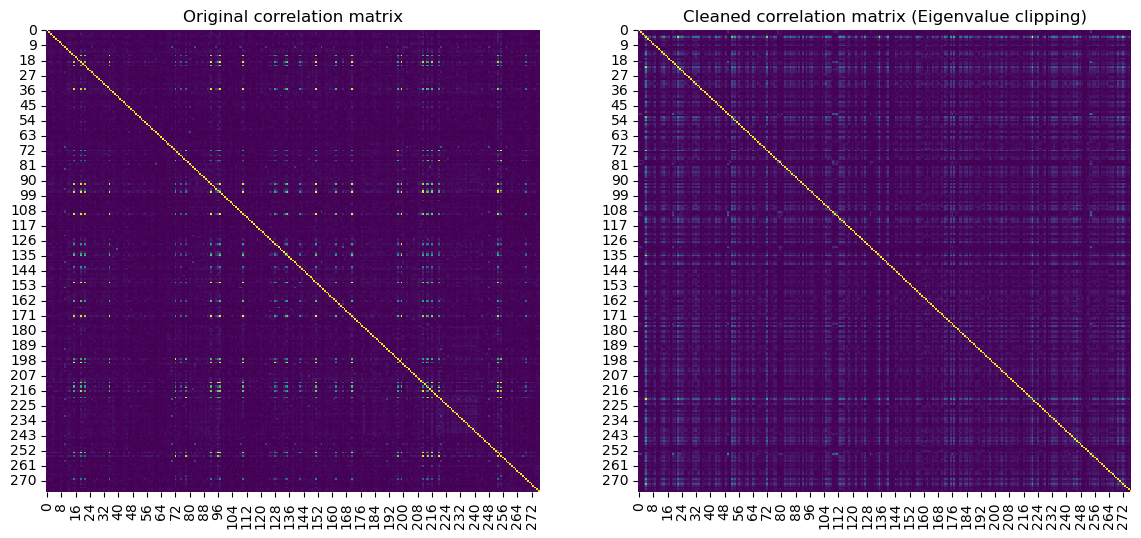

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(np.abs(correlation_hy_1day_sorted), cmap="viridis", ax=ax[0], cbar=False)
ax[0].set_title("Original correlation matrix")

sns.heatmap(np.abs(correlation_hy_1day_clean_sorted), cmap="viridis", ax=ax[1], cbar=False)
ax[1].set_title("Cleaned correlation matrix (Eigenvalue clipping)")

plt.show()

### Ledoit-Wolf Shrinkage

In [ ]:

def ledoit_wolf(returns: pl.LazyFrame) -> pl.DataFrame:
    """
    Ledoit-Wolf shrinkage estimator for the covariance matrix.
    From https://github.com/WLM1ke/LedoitWolf/tree/master
    Source: http://www.ledoit.net/honey.pdf
    """
    returns = returns.collect(streaming=True).drop("index")

    T, N = returns.shape
    mean_returns = returns.mean().to_numpy()[0]
    returns -= mean_returns # bug here tried for loop on column - mean[i]
    sample_cov = (returns.transpose() @ returns / T).to_numpy()

    var = np.diag(sample_cov).reshape(-1, 1)
    std = np.sqrt(var)
    unit_corr_var = std * std.transpose()
    average_corr = ((sample_cov / unit_corr_var).sum() - N) / N / (N - 1)
    prior = average_corr * unit_corr_var
    np.fill_diagonal(prior, var)

    # pi-hat
    y = returns ** 2
    phi_mat = (y.transpose() @ y) / T - sample_cov ** 2
    phi = phi_mat.sum()

    # rho-hat
    theta_mat = ((returns ** 3).transpose() @ returns) / T - var * sample_cov
    np.fill_diagonal(theta_mat, 0)
    rho = (
        np.diag(phi_mat).sum()
        + average_corr * (1 / std @ std.transpose() * theta_mat).sum()
    )

    # gamma-hat
    gamma = np.linalg.norm(sample_cov - prior, "fro") ** 2

    # shrinkage constant
    kappa = (phi - rho) / gamma
    shrink = max(0, min(1, kappa / T))

    # estimator
    sigma = shrink * prior + (1 - shrink) * sample_cov

    return sigma, average_corr, shrink

clean_corr = ledoit_wolf(returns)
eigvals_clean, eigvecs_clean = np.linalg.eig(clean_corr)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

x, mp0 = MP0(eigvals_clean,q,sigma2)
ax[0].hist(eigvals_clean, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[0].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\rho(\lambda)$')
ax[0].legend()

x, mp0 = MP0(eigvals_clean,q,sigma2)
ax[1].hist(eigvals_clean, bins=N, density=True, edgecolor='black', alpha=0.7)
ax[1].plot(x, mp0, label='Marchenko-Pastur Distribution', color='red', alpha=0.7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\log(\lambda$)')
ax[1].set_ylabel(r'$\log(\rho(\lambda))$')
ax[1].legend(loc='upper right')

plt.show()